# Library and Function

In [1]:
import numpy as np
import os
import cv2 as cv
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.preprocessing import image

import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_confidence(y_pred): 
    labels = ['Apple','Banana','Bitter Gourd','Capsicum','Orange','Tomato']
    logits_index = np.argmax(y_pred)
    predicted_label = labels[logits_index]
    confidence = y_pred[0][logits_index] * 100
    return f"Predicted: {predicted_label}\nConfidence: {format(confidence, '.2f')}%"


def get_true_label(true_label:str):
    labels = ['Apple','Banana','Bitter Gourd','Capsicum','Orange','Tomato']
    true_label_index = labels.index(true_label)
    one_hot = [0. for i in range(0,len(labels))]
    one_hot[true_label_index] = 1.
    
    return tf.convert_to_tensor([one_hot])

In [26]:
get_true_label('Banana')

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=array([[0., 1., 0., 0., 0., 0.]], dtype=float32)>

# Load Model

In [3]:
model = tf.keras.models.load_model('fruits.h5')

# Load and proces the Input Image

In [4]:
for i in os.listdir('sample'):
    print(i)

apple.png
banana.png
bitterGourd.jpg
capsicum.jpg
orange.png
tomato.jpg


In [39]:
path = r"sample\banana.png"

img = image.load_img(path, target_size=(280, 280))
img_array = image.img_to_array(img)
img_array = img_array.reshape((280, 280, 3))
img_array = img_array / 255.0  # Normalize pixel values
img_array = np.expand_dims(img_array, axis=0)

# Predict

1/1 [==============================] - 1s 590ms/step


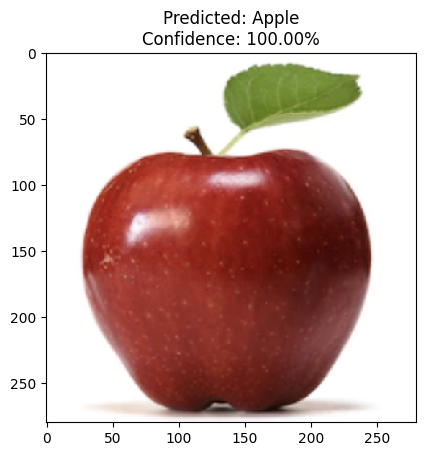

In [34]:
y_pred = model.predict(img_array)
plt.imshow(img)
plt.title(get_confidence(y_pred))
plt.show()

# FGSM

In [30]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad

In [35]:
label = get_true_label('Apple')

perturbations = create_adversarial_pattern(tf.convert_to_tensor(img_array), 
                                           label)

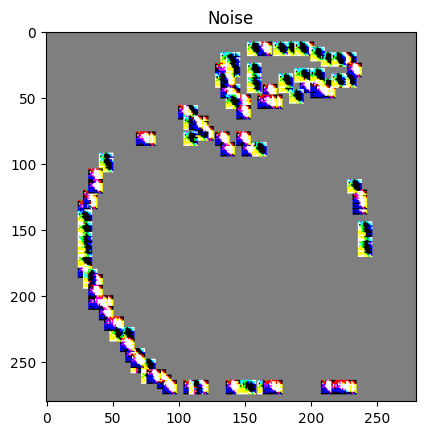

In [36]:
plt.imshow(perturbations[0]*0.5 + 0.5)
plt.title("Noise")
plt.show()

1/1 [==============================] - 0s 453ms/step


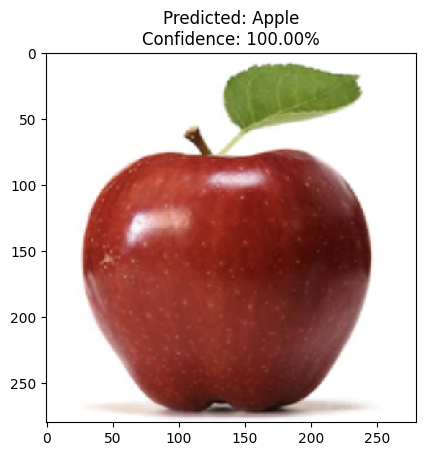

In [37]:
epsilon = 0.01
adv_x = img_array + epsilon * perturbations
adv_x = tf.clip_by_value(adv_x, -1, 1)
y_pred_adv = model.predict(adv_x)


plt.imshow(adv_x[0])
plt.title(get_confidence(y_pred_adv))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


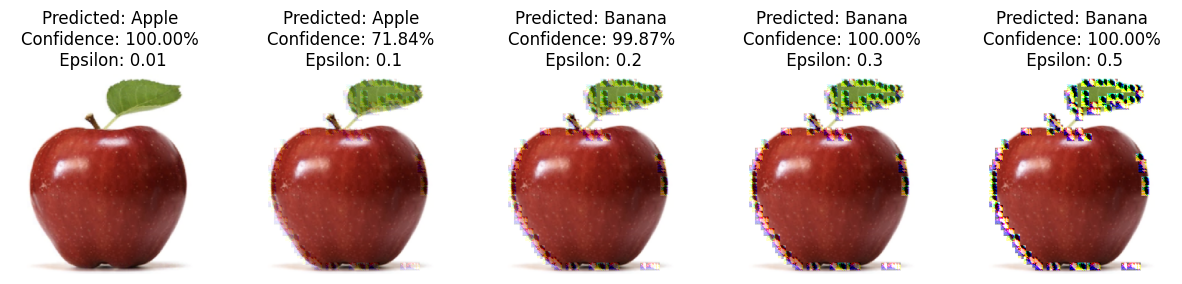

In [38]:
epsilon = [0.01, 0.1, 0.2, 0.3, 0.5]

fig = plt.figure(figsize=(15,15))

for idx,eps in enumerate(epsilon): 
    adv_x = img_array + eps * perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    y_pred_adv = model.predict(adv_x, verbose=0)
    
    fig.add_subplot(1, len(epsilon), idx+1)
    plt.imshow(adv_x[0])
    plt.title(get_confidence(y_pred_adv) + f"\n Epsilon: {eps}")
    plt.axis('off')
plt.show()

# One-Pixel Attack

In [40]:
def one_pixel(image, xs:list, expand_dims=False):
    x,y,r,g,b = xs
    if len(image.shape) > 3: 
        image = np.squeeze(image)
    image[x][y] = (r,g,b)
    
    if expand_dims:
        image = np.expand_dims(image, axis=0)
    
    return image

## Example

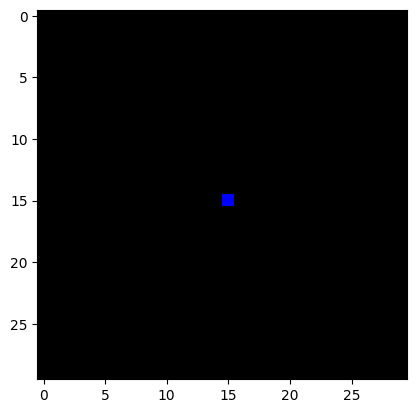

In [20]:
blank_image = np.zeros((30, 30, 3), dtype=np.uint8) 
coba = one_pixel(blank_image, [15, 15, 0,0,255])
plt.imshow(coba)
plt.show()

## Attacking

1/1 [==============================] - 0s 465ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


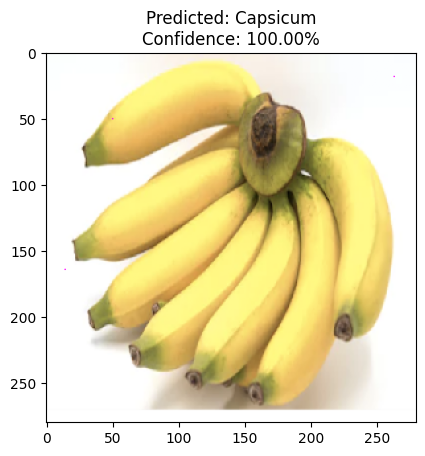

In [44]:
import random

x_random = random.randint(1, 280)
y_random = random.randint(1, 280)

image_perturbed = one_pixel(img_array, [x_random, y_random, 255,0,255], expand_dims=False)

image_perturbed_for_prediction = np.expand_dims(image_perturbed, axis=0)
one_pixel_attack = model.predict(image_perturbed_for_prediction)

plt.imshow(image_perturbed)
plt.title(get_confidence(one_pixel_attack))
plt.show()